# ML Group Assignment 1 

## Group 15

Yuwei Hou-02072327\
Shiyun Chu-02064863\
Rong Yu-02008688\
Jiahui Li-01902365

## Exercise 1

### 1.1 Zachary Karate Club (Calculate the Structure and Plot Communities)

Zachary’s network at an American university is known to consist of two different communities with a total of 34 nodes, each corresponding to the club members that where sided with one of the two club leaders during a dispute.

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# Opened the file in ‘rb’ mode
fh = open("zachary_karate_club.txt", "rb") 

# Read a graph from a list of edges
G_z = nx.read_edgelist(fh)

# Close the file
fh.close() 
len(G_z.nodes), len(G_z.edges)

(34, 78)

So we know that the Zachary's Karate Club network consists of 34 nodes and 78 edges. Each node represents a member of the karate club and each edge represents a ties between two members of the club.

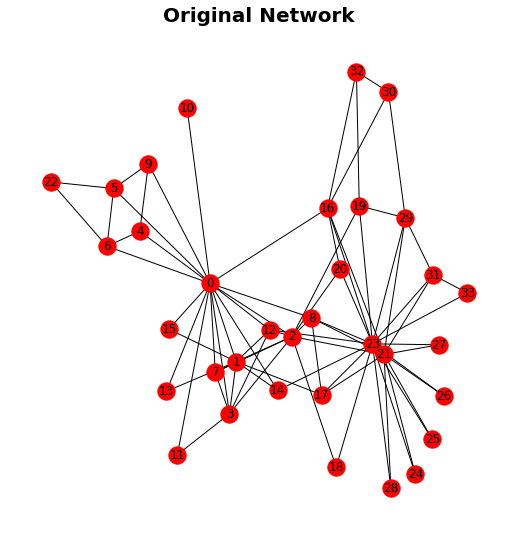

In [8]:
# Plot the original network 
# We will use spring layout here which conducts a pseudo-physics simulation of the movements of the nodes assuming that each edge is a spring with a ﬁxed equilibrium distance. 
# This heuristic algorithm tends to bring groups of well-connected nodes closer to each other, making the visualization more meaningful and aesthetically more pleasing.
fig = plt.figure(1, figsize=(7, 7))
nx.draw(
        G_z,
        with_labels=True,
        node_size=300,
        node_color="red",
        edge_color="black",
        pos=nx.spring_layout(G_z) 
       )
plt.title("Original Network", fontsize=20, fontweight="bold")
plt.show()

### The Girvan-Newman algorithm (Zachary's Karate Club network)

Now we apply the the Girvan-Newman algorithm to detect the community in this club. This algorithm was introduced by Michelle Girvan and Mark Newman. It relies on the iterative elimination of edges that have the highest number of shortest paths between nodes passing through them. Once the edges with the highest betweenness are eliminated, the underlying community structure of the network will be much more fine-grained which means that communities will be much easier to spot. By removing edges from the graph one-by-one, the network breaks down into smaller pieces, so-called communities. 

In [9]:
# Apply the girvan_newman algorithm to detect the community in Zachary's Karate Club network 
com_z = nx.algorithms.community.centrality.girvan_newman(G_z)

# Since the Zachary's Karate Club network is known to have two different communities,
# we could use the following code to have a look at the nodes in each community
com_list = tuple(sorted(c) for c in next(com_z))

print(f'The first community includes nodes: {com_list[0]}')
print(f'The second community includes nodes: {com_list[1]}')

The first community includes nodes: ['0', '1', '10', '11', '12', '13', '14', '15', '22', '3', '4', '5', '6', '7', '9']
The second community includes nodes: ['16', '17', '18', '19', '2', '20', '21', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '8']


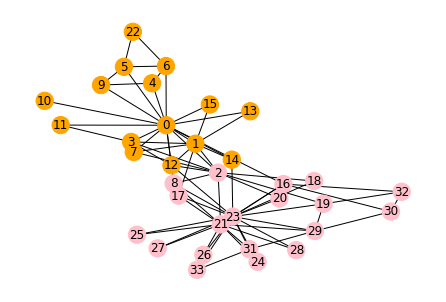

In [10]:
# Plot two communities detected from the girvan_newman algorithm 

colour_map = [] # create a list to store the colour of each node

for i in G_z.nodes:
    if i in com_list[0]:
        colour_map.append('orange')
    else: 
        colour_map.append('pink')  

nx.draw(G_z, node_color=colour_map, with_labels=True)

plt.show()

As we know, the Girvan-Newman algorithm will repeat until there are no more edges left. What we plot above is just the first pair identified from the algorithm. As the graph breaks down into pieces, the tightly knit community structure is exposed and the result can be depicted as a dendrogram. Here we try to plot the dendrogram and have a look at how the community is broken down step by step.

In [55]:
# define a function to draw the dendrogram for the Girvan-Newman algorithm
def girvan_newman_dendrogram (G):

    from itertools import chain, combinations

    # get simulated Graph() and Girvan-Newman communities list
    communities = list(nx.community.girvan_newman(G))

    # building initial dict of node_id to each possible subset:
    node_id = 0
    init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])}
    for comm in communities:
        for subset in list(comm):
            if subset not in init_node2community_dict.values():
                node_id += 1
                init_node2community_dict[node_id] = subset

    # turning this dictionary to the desired format in @mdml's answer
    node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
    for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
        for node_id_parent, group in init_node2community_dict.items():
            if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
                node_id_to_children[node_id_parent].append(node_id1)
                node_id_to_children[node_id_parent].append(node_id2)

    # also recording node_labels dict for the correct label for dendrogram leaves
    node_labels = dict()
    for node_id, group in init_node2community_dict.items():
        if len(group) == 1:
            node_labels[node_id] = list(group)[0]
        else:
            node_labels[node_id] = ''

    # also needing a subset to rank dict to later know within all k-length merges which came first
    subset_rank_dict = dict()
    rank = 0
    for e in communities[::-1]:
        for p in list(e):
            if tuple(p) not in subset_rank_dict:
                subset_rank_dict[tuple(sorted(p))] = rank
                rank += 1
    subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank

    # my function to get a merge height so that it is unique (probably not that efficient)
    def get_merge_height(sub):
        sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
        n = len(sub_tuple)
        other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
        min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
        range = (max_rank-min_rank) if max_rank > min_rank else 1
        return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range

    # finally using @mdml's magic, slightly modified:
    G2          = nx.DiGraph(node_id_to_children)
    nodes       = G2.nodes()
    leaves      = set( n for n in nodes if G2.out_degree(n) == 0 )
    inner_nodes = [ n for n in nodes if G2.out_degree(n) > 0 ]

    # Compute the size of each subtree
    subtree = dict( (n, [n]) for n in leaves )
    for u in inner_nodes:
        children = set()
        node_list = list(node_id_to_children[u])
        while len(node_list) > 0:
            v = node_list.pop(0)
            children.add( v )
            node_list += node_id_to_children[v]
        subtree[u] = sorted(children & leaves)

    inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

    # Construct the linkage matrix
    leaves = sorted(leaves)
    index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
    Z = []
    k = len(leaves)
    for i, n in enumerate(inner_nodes):
        children = node_id_to_children[n]
        x = children[0]
        for y in children[1:]:
            z = tuple(sorted(subtree[x] + subtree[y]))
            i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
            Z.append([i, j, get_merge_height(subtree[n]), len(z)]) # <-- float is required by the dendrogram function
            index[z] = k
            subtree[z] = list(z)
            x = z
            k += 1
    # Draw the dendrogram
    from scipy.cluster.hierarchy import dendrogram
    plt.figure(figsize=(10, 10))
    dn = dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves])
    plt.show()

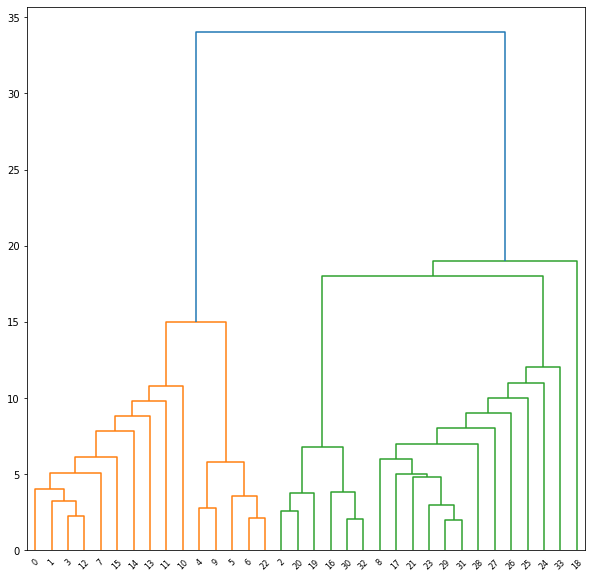

In [56]:
# Draw the dendrogram
girvan_newman_dendrogram (G_z)

As we can see, after we go one step further (devide the network into three communities), node 18 will form a community itself from then on, which does not make much sense as the community size becomes imbalanced. 

In [59]:
# We then try to define a function to plot the communities up to the first k tuples have have a look at how imbalanced the 
# the commnuity would be if divided further 
import itertools

def plot_girvan_communities(G, k, step):
    
    com = nx.algorithms.community.centrality.girvan_newman(G)
    
    # create subplots based on the value of k and step 
    fig, ax = plt.subplots(1, int((k-1)/step+1), figsize=(15,5), clear = True) 
    
    # add title
    fig.suptitle('Communities Graph Using Girvan_Newman Algorithm', fontsize=16)
    
    i = 0
    for com in itertools.islice(com, k): # use itertools.islice() to get only the first k tuples of communities
        # check the step
        if i%step == 0:
            community = tuple(sorted(n) for n in com)
            colours = []
            for n in G.nodes:
                j = 0
                while j < len(community) and n not in community[j]:
                    j+=1
                colours.append(j)
            
            # plot the communities using spring layout 
            nx.draw_spring(G, ax = ax[int((i/step))],cmap = plt.get_cmap('jet'), node_color = colours, node_size=100, width = 0.25, with_labels=True)
            ax[int((i)/step)].set_title('k = '+str((2+i)))
            i += 1
        else :
            i +=1

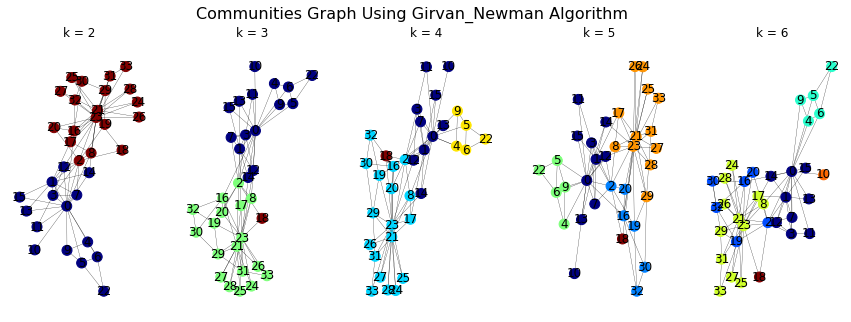

In [62]:
plot_girvan_communities(G_z, 5, 1)

As we can see, there will be single node forms a community itself from k=3, which doesn't make much sense from then on. So it can be argued that the Girvan-Newman algorithm works well with the ground truth of 2 communities, as we can see that the community partitioning results are clear, and the structural hierarchy is well illustrated in the graph. 

### Louvain Package (Zachary's Karate Club network)

Now we apply the louvain package to detect Zachary Karate Club network. The Louvain method is an algorithm to detect communities in large networks. It maximizes a modularity score for each community, where the modularity quantifies the quality of an assignment of nodes to communities. This means evaluating how much more densely connected the nodes within a community are, compared to how connected they would be in a random network. It is a hierarchical clustering algorithm which recursively merges communities into a single node and executes the modularity clustering on the condensed graphs.

In [14]:
# Apply the louvain package to detect Zachary Karate Club network
import community as community_louvain

partition = community_louvain.best_partition(G_z)

group =[]
for i in partition.values():
    if i not in group:
        group.append(i)
print (f'Based on the Louvain package, {len(group)} communities have been detected from the Zachary Karate Club network.')        


Based on the Louvain package, 4 communities have been detected from the Zachary Karate Club network.


In [15]:
# Check nodes in each of these four communities
community_1=[]
community_2=[]
community_3=[]
community_4=[]

for node in G_z.nodes:
    if partition[node]==0:
        community_1.append(node)
    if partition[node]==1:
        community_2.append(node)
    elif partition[node]==2:
        community_3.append(node)
    else:
        community_4.append(node)
print(f'The first community includes nodes: {community_1}')
print(f'The second community includes nodes: {community_2}')
print(f'The third community includes nodes: {community_3}')
print(f'The fourth community includes nodes: {community_4}')

The first community includes nodes: ['0', '1', '2', '3', '7', '10', '11', '12', '13', '14', '15', '18']
The second community includes nodes: ['16', '19', '20', '29', '30', '32']
The third community includes nodes: ['4', '5', '6', '9', '22']
The fourth community includes nodes: ['0', '1', '2', '3', '7', '8', '10', '11', '12', '13', '14', '15', '17', '18', '21', '23', '24', '25', '26', '27', '28', '31', '33']


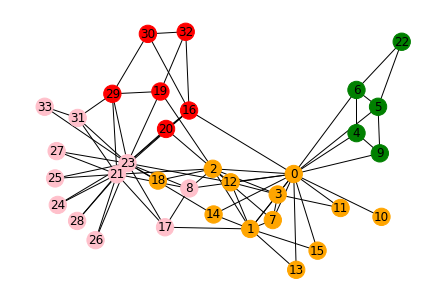

In [25]:
# Plot the communities for the Zachary Karate Club network detected from the louvain package 
color_map = []
for i in G_z.nodes:
    
    if partition[i] == group[0]:
        color_map.append('orange')
        
    elif partition[i] == group[1]:
        color_map.append('green')  
        
    elif partition[i] == group[2]:
        color_map.append('pink')
        
    else:
        color_map.append('red')

nx.draw(G_z, node_color=color_map, with_labels=True)

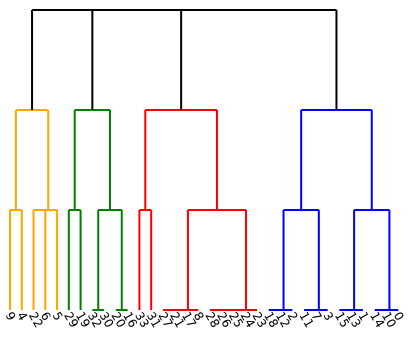

In [24]:
# Plot the dendrogram to have a general idea about how the Louvain algorithm works
from IPython.display import SVG, display
from sknetwork.hierarchy import LouvainHierarchy
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph, svg_dendrogram

louvain_hierarchy_z = LouvainHierarchy()
dendrogram_z = louvain_hierarchy_z.fit_transform(np.array(nx.to_numpy_matrix(G_z)))
image_z = svg_dendrogram(dendrogram_z, np.array(G_z.nodes))
def show_svg(image):
    return SVG(image)
show_svg(image_z)

As we can see from the dendrogram, Louvain hierarchical algorithm uses the optimization of modularity as the algorithm progresses. In the Louvain Method of community detection, first small communities are found by optimizing modularity locally on all nodes, then each small community is grouped into one node and the first step is repeated. In the results, we can see that it divides the Zachary Karate Club deeper than the Girvan_Newman algorithm, into 4 communities. From the Louvain algorithm, we may explore more about the connectivity and relationships between nodes although the ground truth is two communities and the Givan_Newman algorithm also works well in this case.

## 1.2 who-talks-to-whom network (Calculate the Structure and Plot Communities)

As what we did in homework 1, we first need to load the dataset and do some preparion work.

In [3]:
# Load two excel sheets and use columns from A to CD
sent = pd.read_excel("who_talks_to_whom.xlsx",sheet_name = 'Sent', usecols="A:CD")
received = pd.read_excel("who_talks_to_whom.xlsx",sheet_name = 'Received', usecols="A:CD")
# Values like NA and '-' mean there are no emails exchanged, we fill it with 0 and convert the data into 'int' format
sent = sent.fillna(0).replace('-',0).astype(int)
received = received.fillna(0).replace('-',0).astype(int)

# we set the index to be the node label
sent = sent.set_index("Nodes")
received = received.set_index("Nodes")

# Generally speaking, these two tables should be the transpose of each other. However, when we look through the datasets,
# it seems that they are both 'sent' and 'received' tables. 

# First get values from two dataframes
sent_value = sent.values
received_value = received.values

# Here, we assume they are both 'sent' tables, combine the two and takes the maximum if the value is not the same somewhere in two dataframes

sent = pd.DataFrame(np.where(sent_value > received_value, sent_value, received_value), index=sent.index, columns=sent.columns)



In [4]:
# Interpret the 'sent'DataFrame as an adjacency matrix for the graph
G = nx.from_pandas_adjacency(sent)

# Write graph G as adjlist 
nx.write_adjlist(G, "who_talks_to_whom.txt")

# Read the adjlist 'who-talks-to-whom'
G_w = nx.read_adjlist("who_talks_to_whom.txt")

len(G_w.nodes), len(G_w.edges)
print(f'The "who-talks-to-whom" network consists of {len(G_w.nodes)} nodes and {len(G_w.edges)} edges in total.')

The "who-talks-to-whom" network consists of 81 nodes and 1300 edges in total.


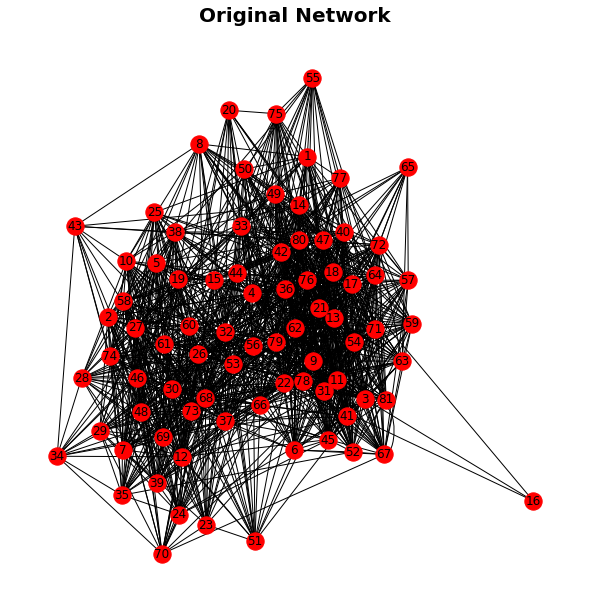

In [44]:
# Plot the original network using spring layout
fig = plt.figure(1, figsize=(8, 8))
nx.draw(
        G_w,
        with_labels=True,
        node_size=300,
        node_color="red",
        edge_color="black",
        pos=nx.spring_layout(G_w)
       )
plt.title("Original Network", fontsize=20, fontweight="bold")
plt.show()

### The Girvan_Newman Algorithm  ('who-talks-to-whom' network)

In [45]:
# Apply the girvan_newman algorithm to detect the community
com_w = nx.algorithms.community.centrality.girvan_newman(G_w)

# Have a look at the first pair of communities
com_list = tuple(sorted(c) for c in next(com_w))

print(f'The first community includes nodes: {com_list[0]}')
print(f'The second community includes nodes: {com_list[1]}')

The first community includes nodes: ['1', '10', '11', '12', '13', '14', '15', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '9']
The second community includes nodes: ['16']


We found the second community only includes one node, the size of two communities are imbalanced.

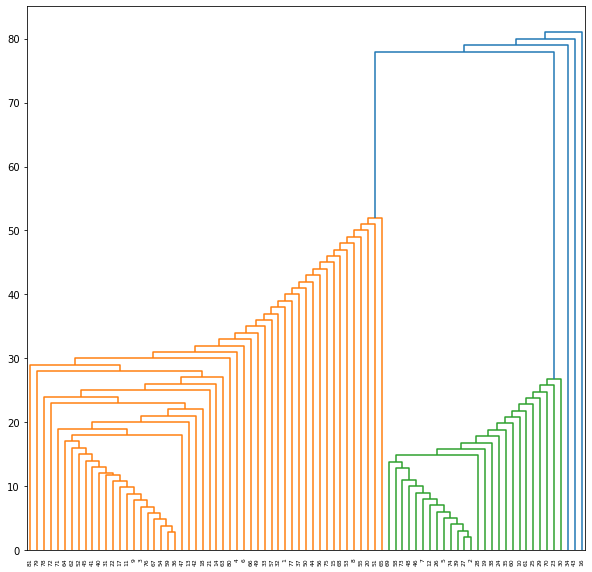

In [57]:
# We now have a look at the dendrogram
girvan_newman_dendrogram(G_w)

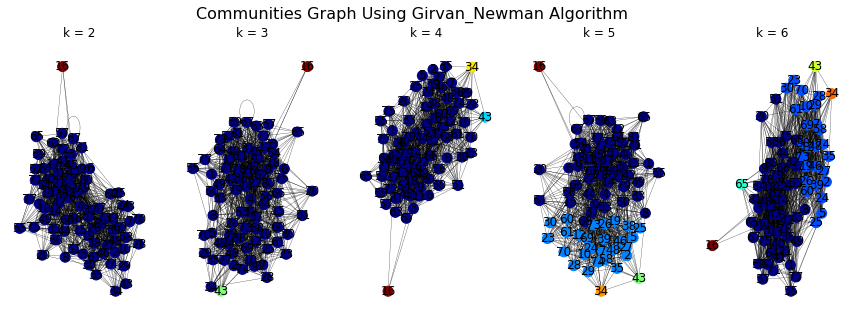

In [63]:
# We then try to plot the communities up to the first k tuples to have have a look at how imbalanced the 
# the commnuity would be if divided further 
plot_girvan_communities(G_w, 5, 1)

As we can see from the dendrogram and above plots, when using the Girvan_Newman algorithm, even after we divide the community deeper, there will be single nodes treated as a community from then on, which does not make much sense as the size of each community is imbalanced.

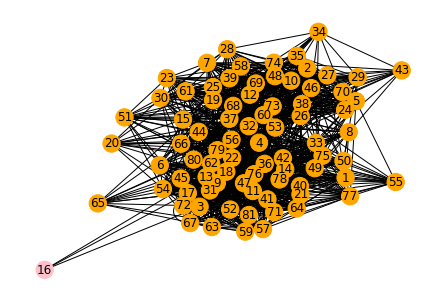

In [66]:
# So we just plot the first pair of communites detected from the girvan_newman algorithm and make it more clear

colour_map = [] # create a list to store the colour of each node
for i in G_w.nodes:
    if i in com_list[0]:
        colour_map.append('orange')
    else: 
        colour_map.append('pink')  

nx.draw(G_w, node_color=colour_map, with_labels=True)

plt.show()

### Louvain package ('who-talks-to-whom' network)

In [52]:
# Apply the louvain package to detect 'who-talk-to-whom' network

partition = community_louvain.best_partition(G_w)

group =[]
for i in partition.values():
    if i not in group:
        group.append(i)
print (f'Based on the Louvain package, {len(group)} communities have been detected from the Zachary Karate Club network')        

Based on the Louvain package, 3 communities have been detected from the Zachary Karate Club network


In [53]:
# Check what nodes are included in each of these three communities
community_1=[]
community_2=[]
community_3=[]

for node in G_w.nodes:
    if partition[node]==0:
        community_1.append(node)
    if partition[node]==1:
        community_2.append(node)
    else:
        community_3.append(node)
print(f'The first community includes nodes: {community_1}')
print(f'The second community includes nodes: {community_2}')
print(f'The third community includes nodes: {community_3}')

The first community includes nodes: ['4', '66', '44', '33', '15', '14', '8', '75', '56', '50', '55', '20']
The second community includes nodes: ['69', '53', '32', '68', '58', '43', '37', '73', '48', '46', '38', '7', '60', '24', '12', '26', '5', '61', '30', '29', '10', '74', '70', '39', '35', '27', '25', '19', '2', '51', '34', '28', '23']
The third community includes nodes: ['81', '80', '79', '78', '72', '71', '64', '62', '52', '47', '45', '42', '41', '40', '31', '22', '21', '17', '13', '11', '9', '4', '3', '1', '76', '67', '66', '65', '63', '57', '54', '44', '33', '18', '15', '14', '8', '6', '75', '59', '56', '50', '77', '55', '49', '36', '20', '16']


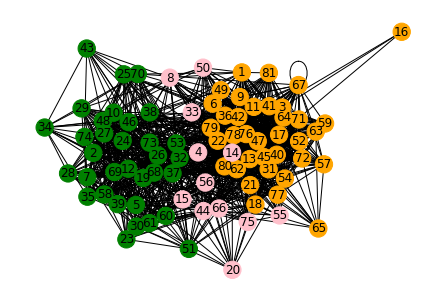

In [58]:
# Plot the communities for the 'who-talk-to-whom' network detected from the louvain package 
color_map = []
for i in G_w.nodes:
    
    if partition[i] == group[0]:
        color_map.append('orange')
        
    elif partition[i] == group[1]:
        color_map.append('green')  
        
    else:
        color_map.append('pink')


nx.draw(G_w, node_color=color_map, with_labels=True)

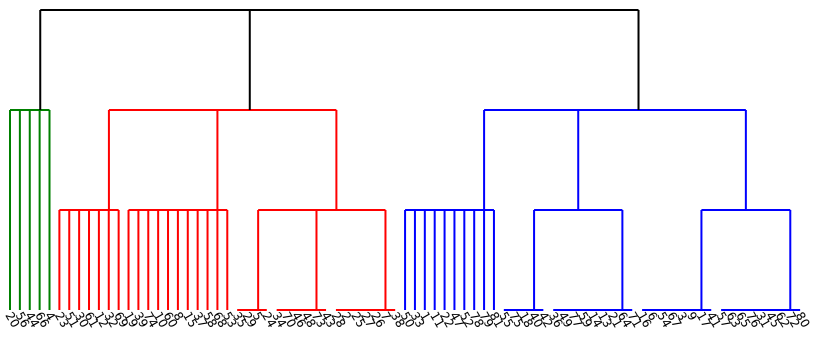

In [68]:
# Draw the dendrogram
louvain_hierarchy_w = LouvainHierarchy()
dendrogram_w = louvain_hierarchy_w.fit_transform(np.array(nx.to_numpy_matrix(G_w)))
image_w = svg_dendrogram(dendrogram_w, np.array(G_w.nodes), width = 800, height = 300)
def show_svg(image):
    return SVG(image)
show_svg(image_w)

In the 'who-talks-to-whom' network, we first used the Gwen-Newman algorithm, and from the results, we can see that there are two communities, but only with node '16' in one community. However, using the Louvain algorithm for the same network, we can see that the network is divided into three different communities, while the node '16' is included in one large community. Since in Louvain, the community is analyzed for modularity to find a hierarchical community structure, with the optimization goal of maximizing the modularity of the whole community network. In the results we can see that the communities are divided in a more detailed and reasonable way compared with using the Girvan-Newman algorithm, which makes it easier to detect correlations between nodes.